In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score, auc,  precision_score, recall_score

In [2]:
import Models

In [3]:
df = pd.read_csv('C:/Users/cheryl/Downloads/df_for_model.csv', encoding='latin-1')

In [4]:
embedded_cols = ["Job Title_embed","Profile_embed","Department_embed","Job_Description_embed","Requirements_embed",
                "Job_Benefits_embed","Type_of_Industry_embed","Operations_embed","City_embed"]
categorical_feats = ["Qualification_bachelor's degree", "Salary_Specified", "Type_of_Employment_unspecified",
                     "Qualification_high school", "City_Specified", "Experience_entry level","Qualification_master's degree",
                     "Experience_unspecified", "Telecomunication","Qualification_vocational / certification/ professional",
                     "Experience_midsenior level", "Qualification_unspecified", "Type_of_Employment_fulltime"]

In [5]:
for col in embedded_cols:
    df[col] = df[col].apply(Models.convert_to_array)

In [6]:
X = Models.flatten(df)

## PCA

In [7]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

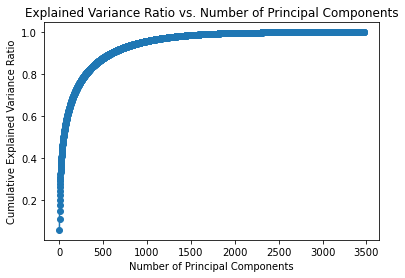

In [8]:
X_pca = Models.do_pca(X_std)

In [9]:
pca = PCA(n_components = 100)
X_pca = pca.fit_transform(X_std)
explained_variance = pca.explained_variance_ratio_
variance_first_100 = explained_variance.sum()
print(f"Variance explained by first 100 components: {variance_first_100:.3f}")

Variance explained by first 100 components: 0.618


## Train-Test Split

In [10]:
df1 = pd.DataFrame(X_pca)
y = df['Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.2, random_state = 4263)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8524, 100)
(2132, 100)
(8524,)
(2132,)


In [11]:
print("Counts of label '1' in training data: {}".format(sum(y_train == 1)))
print("Counts of label '0' in training data: {}".format(sum(y_train == 0)))

Counts of label '1' in training data: 588
Counts of label '0' in training data: 7936


## Resampling

In [12]:
X_train_ros, y_train_ros = Models.resampling_method('Oversampling',X_train,y_train)

Resampled class counts:
0    7936
1    7936
Name: Fraudulent, dtype: int64


In [13]:
X_train_rus, y_train_rus = Models.resampling_method('Undersampling',X_train,y_train)

Resampled class counts:
0    588
1    588
Name: Fraudulent, dtype: int64


## Logistic regression (without tuning)

In [14]:
logistic_model = LogisticRegression(solver='liblinear',random_state = 4263)

logistic_model.fit(X_train_ros, y_train_ros)

# Make predictions
y_pred = logistic_model.predict(X_test)

Accuracy: 0.899624765478424
f1-score: 0.5244444444444444
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1990
           1       0.38      0.83      0.52       142

    accuracy                           0.90      2132
   macro avg       0.68      0.87      0.73      2132
weighted avg       0.95      0.90      0.92      2132



array([[1800,  190],
       [  24,  118]], dtype=int64)

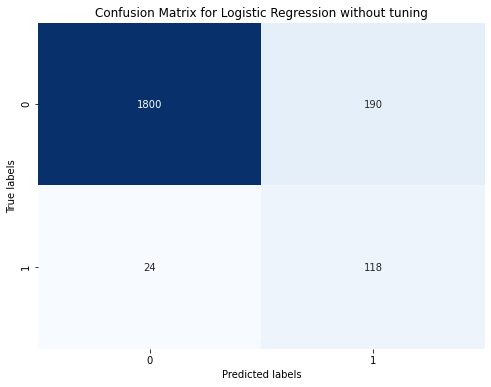

In [15]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression without tuning')

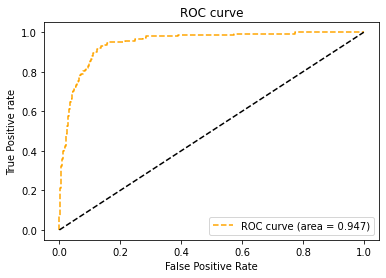

AUC score: 0.947


In [16]:
Models.auc_roc(logistic_model,'Logistic Regression without tuning',X_test,y_test)

Accuracy: 0.8846153846153846
f1-score: 0.5020242914979758
              precision    recall  f1-score   support

           0       0.99      0.89      0.93      1990
           1       0.35      0.87      0.50       142

    accuracy                           0.88      2132
   macro avg       0.67      0.88      0.72      2132
weighted avg       0.95      0.88      0.91      2132



array([[1762,  228],
       [  18,  124]], dtype=int64)

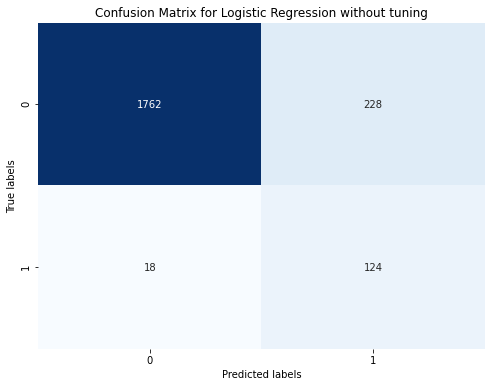

In [43]:
logistic_model.fit(X_train_rus, y_train_rus)

# Make predictions
y_pred = logistic_model.predict(X_test)
Models.evaluate_model(y_test,y_pred,'Logistic Regression without tuning')

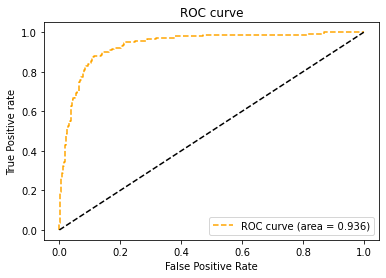

AUC score: 0.936


In [44]:
Models.auc_roc(logistic_model,'Logistic Regression without tuning',X_test,y_test)

## Logistic regression (with tuning)

In [18]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # L1 (Lasso) or L2 (Ridge) regularization
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(logistic_model, 
                           param_grid, 
                           cv=5, 
                           scoring= ['precision','recall'],
                           refit = 'recall',
                           n_jobs=-1)
grid_search.fit(X_train_ros,y_train_ros)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Accuracy: 0.9435474629348342
Test Accuracy: 0.8869606003752345


Accuracy: 0.8869606003752345
f1-score: 0.5071574642126789
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1990
           1       0.36      0.87      0.51       142

    accuracy                           0.89      2132
   macro avg       0.67      0.88      0.72      2132
weighted avg       0.95      0.89      0.91      2132



array([[1767,  223],
       [  18,  124]], dtype=int64)

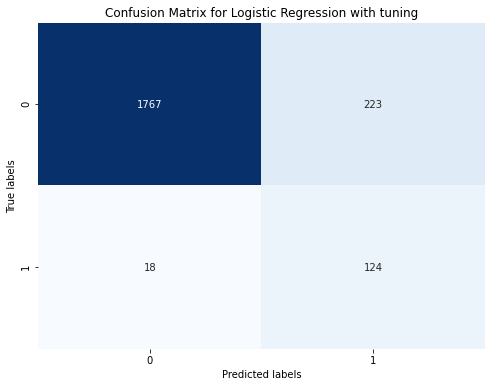

In [19]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression with tuning')

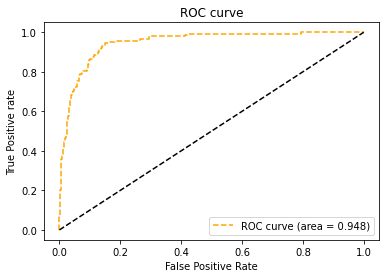

AUC score: 0.948


In [20]:
Models.auc_roc(best_model,'Logistic Regression with tuning',X_test,y_test)

In [45]:
grid_search.fit(X_train_rus,y_train_rus)
# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Accuracy: 0.9420831522526438
Test Accuracy: 0.7931519699812383


Accuracy: 0.7931519699812383
f1-score: 0.37446808510638296
              precision    recall  f1-score   support

           0       0.99      0.78      0.88      1990
           1       0.23      0.93      0.37       142

    accuracy                           0.79      2132
   macro avg       0.61      0.86      0.63      2132
weighted avg       0.94      0.79      0.84      2132



array([[1559,  431],
       [  10,  132]], dtype=int64)

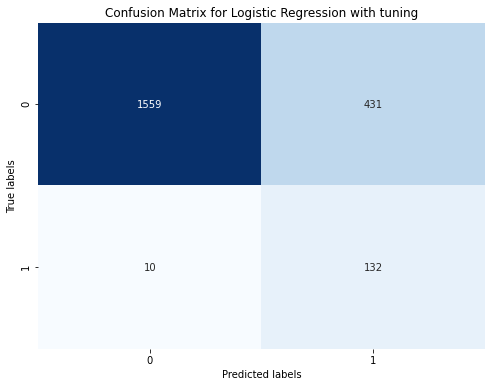

In [46]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression with tuning')

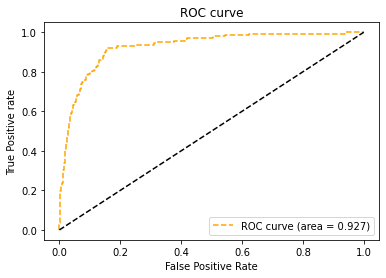

AUC score: 0.927


In [47]:
Models.auc_roc(best_model,'Logistic Regression with tuning',X_test,y_test)

## Random Forest (without tuning)

In [21]:
rfc = RandomForestClassifier(random_state = 4263)
rfc.fit(X_train_ros, y_train_ros)
y_pred = rfc.predict(X_test)

Accuracy: 0.9666979362101313
f1-score: 0.6697674418604651
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1990
           1       0.99      0.51      0.67       142

    accuracy                           0.97      2132
   macro avg       0.98      0.75      0.83      2132
weighted avg       0.97      0.97      0.96      2132



array([[1989,    1],
       [  70,   72]], dtype=int64)

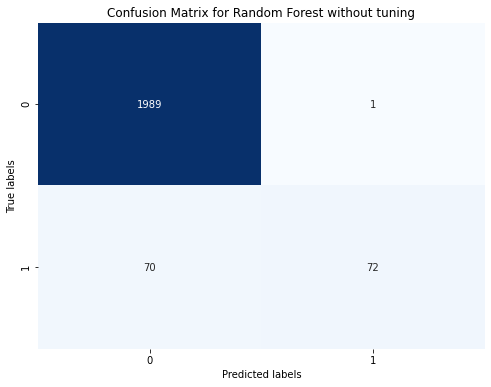

In [22]:
Models.evaluate_model(y_test,y_pred,'Random Forest without tuning')

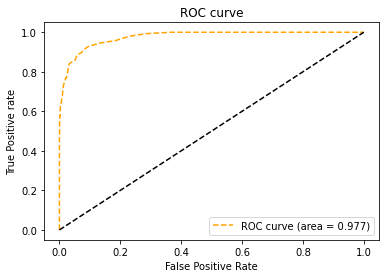

AUC score: 0.977


In [23]:
Models.auc_roc(rfc,'Random Forest without tuning',X_test,y_test)

Accuracy: 0.9169793621013134
f1-score: 0.5607940446650124
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1990
           1       0.43      0.80      0.56       142

    accuracy                           0.92      2132
   macro avg       0.71      0.86      0.76      2132
weighted avg       0.95      0.92      0.93      2132



array([[1842,  148],
       [  29,  113]], dtype=int64)

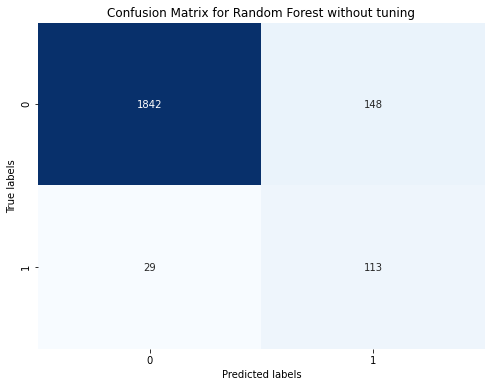

In [48]:
rfc.fit(X_train_rus, y_train_rus)
y_pred = rfc.predict(X_test)
Models.evaluate_model(y_test,y_pred,'Random Forest without tuning')

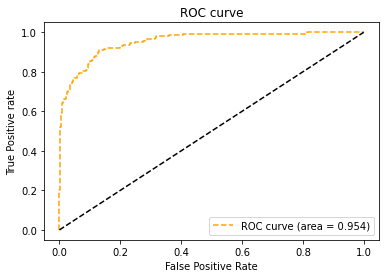

AUC score: 0.954


In [49]:
Models.auc_roc(rfc,'Random Forest without tuning',X_test,y_test)

## Random Forest (with tuning)

In [61]:
rfc = RandomForestClassifier(random_state = 4263, 
                             max_features = 'sqrt',
                             n_estimators= 50,
                             max_depth = 9, 
                             criterion = 'gini',
                             n_jobs=-1)
rfc.fit(X_train_ros, y_train_ros)
y_pred = rfc.predict(X_test)

Accuracy: 0.9610694183864915
f1-score: 0.7046263345195729
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1990
           1       0.71      0.70      0.70       142

    accuracy                           0.96      2132
   macro avg       0.85      0.84      0.84      2132
weighted avg       0.96      0.96      0.96      2132



array([[1950,   40],
       [  43,   99]], dtype=int64)

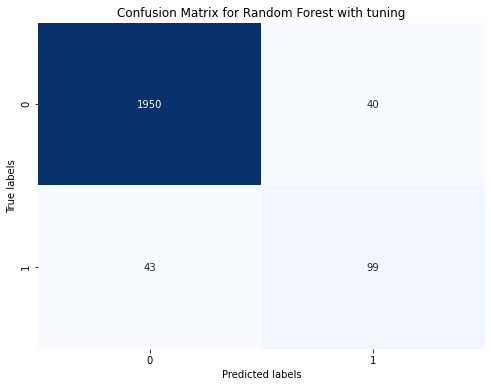

In [62]:
Models.evaluate_model(y_test,y_pred,'Random Forest with tuning')

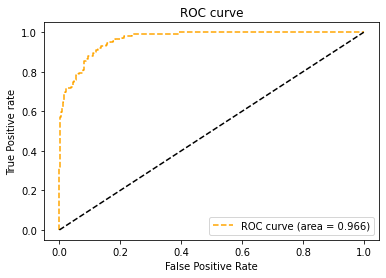

AUC score: 0.966


In [63]:
Models.auc_roc(rfc,'Random Forest with tuning',X_test,y_test)

Accuracy: 0.9183864915572233
f1-score: 0.5756097560975609
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1990
           1       0.44      0.83      0.58       142

    accuracy                           0.92      2132
   macro avg       0.71      0.88      0.77      2132
weighted avg       0.95      0.92      0.93      2132



array([[1840,  150],
       [  24,  118]], dtype=int64)

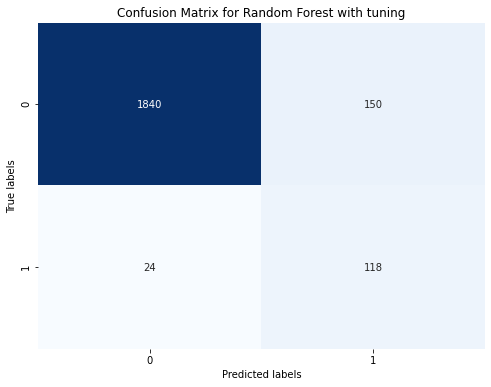

In [78]:
rfc = RandomForestClassifier(random_state = 4263, 
                             max_features = 'sqrt',
                             n_estimators= 100,
                             max_depth = 10, 
                             criterion = 'gini',
                             n_jobs=-1)
rfc.fit(X_train_rus, y_train_rus)
y_pred = rfc.predict(X_test)
Models.evaluate_model(y_test,y_pred,'Random Forest with tuning')

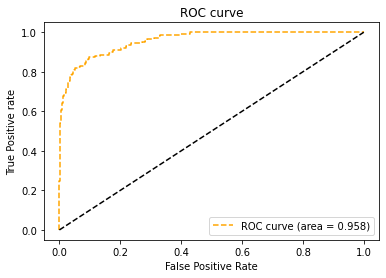

AUC score: 0.958


In [79]:
Models.auc_roc(rfc,'Random Forest with tuning',X_test,y_test)

## Neural Networks

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [81]:
num_features = X_train_ros.shape[1]
print(num_features)

100


In [82]:
# Build the model
nn_model = Sequential([
    Input(shape=(num_features,)),  # Input layer
    Dense(128, activation='relu'), # First hidden layer
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1, activation='sigmoid') # Output layer (binary classification)
])
optimizer = Adam(learning_rate=0.001)  
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall()])

# Print model summary
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               12928     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23297 (91.00 KB)
Trainable params: 23297 (91.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
nn_model.fit(X_train_ros,
             y_train_ros,
             epochs=10, 
             batch_size=32,
             validation_data=(X_test, y_test))

Epoch 1/10
496/496 [==============================] - 3s 3ms/step - loss: 0.1258 - accuracy: 0.9529 - recall_2: 0.9640 - val_loss: 0.1080 - val_accuracy: 0.9620 - val_recall_2: 0.7887
Epoch 2/10
496/496 [==============================] - 1s 2ms/step - loss: 0.0222 - accuracy: 0.9939 - recall_2: 0.9971 - val_loss: 0.1042 - val_accuracy: 0.9686 - val_recall_2: 0.8521
Epoch 3/10
496/496 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9980 - recall_2: 0.9994 - val_loss: 0.1172 - val_accuracy: 0.9737 - val_recall_2: 0.7113
Epoch 4/10
496/496 [==============================] - 1s 2ms/step - loss: 0.0087 - accuracy: 0.9975 - recall_2: 0.9985 - val_loss: 0.1227 - val_accuracy: 0.9756 - val_recall_2: 0.7465
Epoch 5/10
496/496 [==============================] - 1s 2ms/step - loss: 0.0151 - accuracy: 0.9951 - recall_2: 0.9962 - val_loss: 0.1230 - val_accuracy: 0.9770 - val_recall_2: 0.7606
Epoch 6/10
496/496 [==============================] - 1s 2ms/step - loss: 6.7317

In [84]:
results = nn_model.evaluate(X_test, y_test)
accuracy = results[1]
recall = results[2]
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")

67/67 [==============================] - 0s 2ms/step - loss: 0.1523 - accuracy: 0.9780 - recall_2: 0.7535
Test Accuracy: 0.9780
Test Recall: 0.7535


In [85]:
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred).tolist()

67/67 [==============================] - 0s 1ms/step


Accuracy: 0.9779549718574109
f1-score: 0.8199233716475096
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1990
           1       0.90      0.75      0.82       142

    accuracy                           0.98      2132
   macro avg       0.94      0.87      0.90      2132
weighted avg       0.98      0.98      0.98      2132



array([[1978,   12],
       [  35,  107]], dtype=int64)

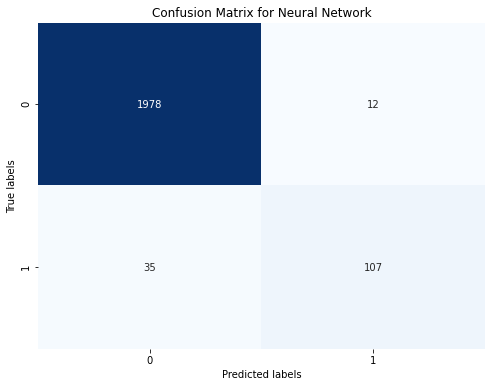

In [86]:
Models.evaluate_model(y_test,y_pred,'Neural Network')

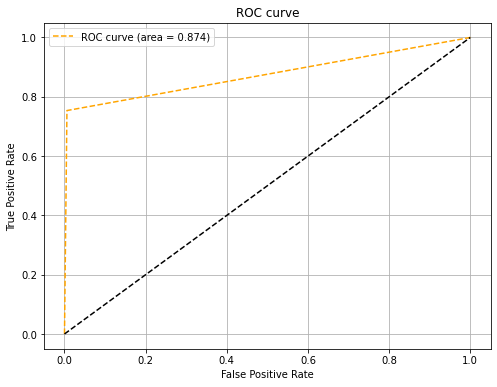

In [87]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--',color='orange', label ='ROC curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [88]:
nn_model.fit(X_train_rus,
             y_train_rus,
             epochs=10, 
             batch_size=32,
             validation_data=(X_test, y_test))

Epoch 1/10
37/37 [==============================] - 1s 8ms/step - loss: 4.2494e-05 - accuracy: 1.0000 - recall_2: 1.0000 - val_loss: 0.1534 - val_accuracy: 0.9780 - val_recall_2: 0.7535
Epoch 2/10
37/37 [==============================] - 0s 5ms/step - loss: 3.6655e-05 - accuracy: 1.0000 - recall_2: 1.0000 - val_loss: 0.1538 - val_accuracy: 0.9780 - val_recall_2: 0.7535
Epoch 3/10
37/37 [==============================] - 0s 7ms/step - loss: 3.3457e-05 - accuracy: 1.0000 - recall_2: 1.0000 - val_loss: 0.1539 - val_accuracy: 0.9780 - val_recall_2: 0.7535
Epoch 4/10
37/37 [==============================] - 0s 8ms/step - loss: 3.1125e-05 - accuracy: 1.0000 - recall_2: 1.0000 - val_loss: 0.1538 - val_accuracy: 0.9780 - val_recall_2: 0.7535
Epoch 5/10
37/37 [==============================] - 0s 9ms/step - loss: 2.9248e-05 - accuracy: 1.0000 - recall_2: 1.0000 - val_loss: 0.1535 - val_accuracy: 0.9775 - val_recall_2: 0.7535
Epoch 6/10
37/37 [==============================] - 0s 6ms/step - loss

In [89]:
results = nn_model.evaluate(X_test, y_test)
accuracy = results[1]
recall = results[2]
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")

67/67 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9775 - recall_2: 0.7535
Test Accuracy: 0.9775
Test Recall: 0.7535


67/67 [==============================] - 0s 2ms/step
Accuracy: 0.9774859287054409
f1-score: 0.816793893129771
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1990
           1       0.89      0.75      0.82       142

    accuracy                           0.98      2132
   macro avg       0.94      0.87      0.90      2132
weighted avg       0.98      0.98      0.98      2132



array([[1977,   13],
       [  35,  107]], dtype=int64)

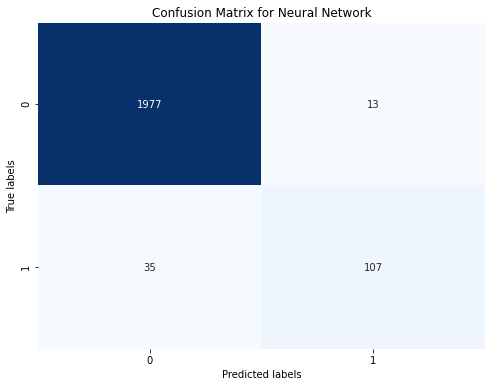

In [90]:
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred).tolist()
Models.evaluate_model(y_test,y_pred,'Neural Network')

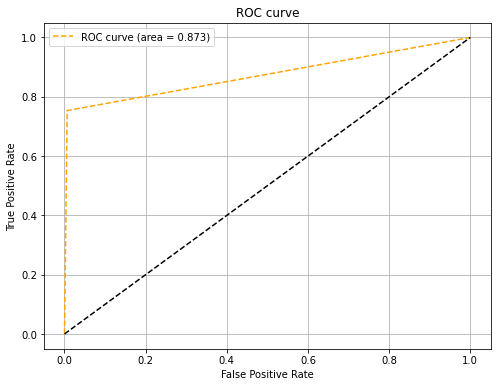

In [91]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--',color='orange', label ='ROC curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()